In [53]:
%matplotlib inline

import os
import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from skimage.transform import resize
from skimage import io
from particle_model import Particle, Sphere
from records import DENSITIES, TERMINAL_VELOCITIES, RADIUS
import json  # import the library that stores the particle configurations

with open('particle_configurations.json') as f:
    configurations = json.load(f)

In [156]:
def scale_values(data, scale, frame_rate, time_scale):
    """
    This function scales the x, y, and time values in the given data.
    :param data: The original data
    :param scale: The 3-D scale factor for x and y
    :param frame_rate: Frame rate of the video, for converting frame number to time
    :param time_scale: The timescale tau (tau = r/v_light)
    :return: Scaled x, y, and time values
    """
    scaled_x = data['x'] / (scale * RADIUS)
    scaled_y = data['y'] / (scale * RADIUS)
    scaled_time = (data['frame'] / frame_rate) / time_scale

    return scaled_x, scaled_y, scaled_time

In [121]:
def rolling_average(data, neigh_num):
    """
    Calculate the moving average of flame depth with pandas.rolling() method. Larger neighbor number makes the array shorter because the beginning and ending elements are NaNs.
    :param data: the original data array before smoothening.
    :param neigh_num: number of neighbors on each side to be averaged.
    :return: smoothened data array with the first and last neighbors being NaNs
    """
    # calculate the window size according to the neighbor number
    window_size = 2*neigh_num + 1

    # determine the averaged data array by using the pandas.rolling() method
    new_data = pd.Series(data).rolling(window_size, center=True).mean().values

    return new_data

In [149]:
def five_point_stencil(t, data):
    """
    Calculate the derivative using five-point stencil method
    :param t: original time array before differentiation
    :param data: original data array before differentiation
    :return: arrays of time and derivative without the first and the last several elements.
    """

    # since this method uses the surrounding four elements around the desired point,
    # the derivative array will be four elements shorter than the original array.
    new_t = t[2:-2]
    derivative = np.empty(len(data) - 4)

    for i in range(2, len(data) - 2):
        derivative[i - 2] = (-data[i + 2] + 8 * data[i + 1] - 8 * data[i - 1] + data[i - 2]) / 12

    return new_t, derivative

In [150]:
def forward_difference(t, data):
    """
    Calculate the forward discrete difference using np.diff()
    :param t: original time array before differentiation
    :param data: original data array before differentiation
    :return: arrays of time and derivative without the first element.
    """
    new_t = t[:-1]
    derivative = np.diff(data)

    return new_t, derivative

In [151]:
# This function creates and initializes particles based on the configuration provided
def create_particle(name):
    # retrieve configuration from the library by name
    configuration = configurations[name]
    p = Particle()  # instantiate a particle object

    # instantiate sphere objects
    for sphere_config in configuration:
        s = Sphere(sphere_config["center"], sphere_config["radius"], sphere_config["material"])
        p.add_sphere(s)

    return p

# This function visualizes the particle in 3D interactive domain
def plot_particle(particle, name, ax, transparency=False):
    min_val = np.inf
    max_val = -np.inf
    # Create a list to hold the legend entries
    legend_elements = []

    for s in particle.spheres:
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = s.center[0] + s.radius * np.outer(np.cos(u), np.sin(v))
        y = s.center[1] + s.radius * np.outer(np.sin(u), np.sin(v))
        z = s.center[2] + s.radius * np.outer(np.ones(np.size(u)), np.cos(v))

        min_val = min(min_val, np.min(x), np.min(y), np.min(z))
        max_val = max(max_val, np.max(x), np.max(y), np.max(z))

        ax.plot_surface(x, y, z, color=s.color, alpha=0.5 if transparency else 1)

        # create a patch for the material if it's not already in the legend
        if s.material.capitalize() not in [element.get_label() for element in legend_elements]:
            legend_elements.append(Patch(facecolor=s.color, edgecolor=s.color, label=s.material.capitalize()))

    # Plot center of mass
    com = particle.center_of_mass
    mass_center = ax.scatter(com[0], com[1], com[2], color="r", s=30, marker='*')

    # Plot center of geometry
    cog = particle.center_of_geometry
    geometry_center = ax.scatter(cog[0], cog[1], cog[2], color="k", s=30, marker='x')

    # Create legend
    ax.legend([mass_center, geometry_center], ['Center of Mass', 'Geometric Center'])

    # Set title and capitalize each word as well as the element name
    title = name.title()
    ax.set_title(title + f", $\\chi={particle.offset:.2f}$, $\\theta={particle.theta}^o$, $\\phi={particle.phi}^o$")

    ax.set_xlim3d([min_val, max_val])
    ax.set_ylim3d([min_val, max_val])
    ax.set_zlim3d([min_val, max_val])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    # add the legend
    ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(1.1, -0.25))

    ax.set_box_aspect([1,1,1])

In [160]:
def plot_motion(data, scale, frame_rate, time_scale, diff_method, avg_size, ax):
    """
    This function plots the motion properties of the falling particle such as the x & y positions and x & y velocities
    :param data: the tracking data obtained via the TrackPy package
        :param scale: 3-D scale from pixel to mm
    :param frame_rate: frame rate of the video, for converting frame number to time
    :param time_scale: the timescale tau (tau = r/v_light)
    :param diff_method: the method used to differentiate the data
    :param avg_size: the number of neighbors on each side to be averaged
    :param ax: The axis where this figure should be plotted
    :return: motion image at the bottom
    """
    # Create a GridSpec for the 4 plots within the given Axes
    gs_inner = mpl.gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=ax, hspace=0.4)

    # Create 4 sub-axes in the provided ax, but use different variable names
    axa = plt.subplot(gs_inner[0])
    axb = plt.subplot(gs_inner[1], sharex=axa)
    axc = plt.subplot(gs_inner[2], sharex=axa)
    axd = plt.subplot(gs_inner[3], sharex=axa)

    # Scale the time, x and y values
    x, y, time = scale_values(data, scale, frame_rate, time_scale)

    # Calculate the x and y velocities
    if diff_method=="five-point":
        deriv_time, vx = five_point_stencil(time, x)
        deriv_time, vy = five_point_stencil(time, y)
    else:
        deriv_time, vx = forward_difference(time, x)
        deriv_time, vy = forward_difference(time, y)
    vy = np.abs(vy)

    # Smoothen the derivative by taking rolling average
    smoothed_vx = rolling_average(vx, neigh_num=avg_size)
    smoothed_vy = rolling_average(vy, neigh_num=avg_size)
    # Calculate average smoothened velocities, ignoring nans
    avg_vx = np.nanmean(smoothed_vx)
    avg_vy = np.nanmean(smoothed_vy)
    # Calculate the standard deviations, ignoring nans
    std_vx = np.nanstd(smoothed_vx)
    std_vy = np.nanstd(smoothed_vy)

    # X displacement plot
    axa.scatter(time, x, marker='+', label='Data')
    axa.plot([time.iloc[0], time.iloc[-1]], [np.mean(x.iloc[:5]), np.mean(x.iloc[-5:])],
             color='g', linestyle='--', label='Drifting')
    axa.set_ylabel("x/R")
    axa.legend()
    axa.label_outer()  # Hide x tick labels

    # Y displacement plot
    axb.scatter(time, -y, marker='+', label='Data')
    axb.plot([time.iloc[0], time.iloc[-1]], [-np.mean(y.iloc[:5]), -np.mean(y.iloc[-5:])],
             color='g', linestyle='--', label='Drifting')
    axb.set_ylabel("y/R")
    axb.legend()
    axb.label_outer()  # Hide x tick labels

    # X velocity plot
    axc.scatter(deriv_time, smoothed_vx, marker='+', label='Smoothed')
    axc.axhline(y=avg_vx, color='r', linestyle='--', label='Average')
    axc.set_ylim(avg_vx-3*std_vx, avg_vx+3*std_vx)
    axc.set_ylabel("$V_x$")
    axc.legend()
    axc.label_outer()  # Hide x tick labels

    # Y velocity plot
    axd.scatter(deriv_time, smoothed_vy, marker='+', label='Smoothed')
    axd.axhline(y=avg_vy, color='r', linestyle='--', label='Average')
    axd.set_ylim(avg_vy-3*std_vy, avg_vy+3*std_vy)
    axd.set_ylabel("$|V_y|$")
    axd.legend()

    # Let the subplots share x-axis
    axd.set_xlabel("Scaled Time")

In [161]:
def plot_stacked_image(frames, ax):
    # Number of total frames
    total_frames = frames.shape[0]

    # Calculate the interval at which to take slices
    interval = total_frames // 25

    # Select 25 evenly distributed slices from the stack
    selected_frames = frames[::interval]

    # Maximum Intensity Projection of original selected frames
    mip_selected = np.max(selected_frames, axis=0)

    # Display the stacked image
    ax.imshow(mip_selected, cmap='gray')
    ax.set_title('Stacked Image')
    ax.axis('off')

    return mip_selected  # return this so that it can be used in the stretched image function


def plot_stretched_image(mip_selected, ax):
    # Define a new width for the stretched image (e.g., ten times the original width)
    new_width = mip_selected.shape[1] * 20  # change the multiplier as needed

    # Resize the image
    stretched_image = resize(mip_selected, (mip_selected.shape[0], new_width))

    # Display the stretched image
    ax.imshow(stretched_image, cmap='gray', aspect='auto')
    ax.set_title('Stretched Image')
    ax.axis('off')

In [162]:
glacier_path = 'Z:\Mingxuan Liu'
config_name = "tetramer-al-cu-2"  # name of the configuration
folder_name = 'tetramer-al-cu-2-1-6fps'
name_light = 'al'

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


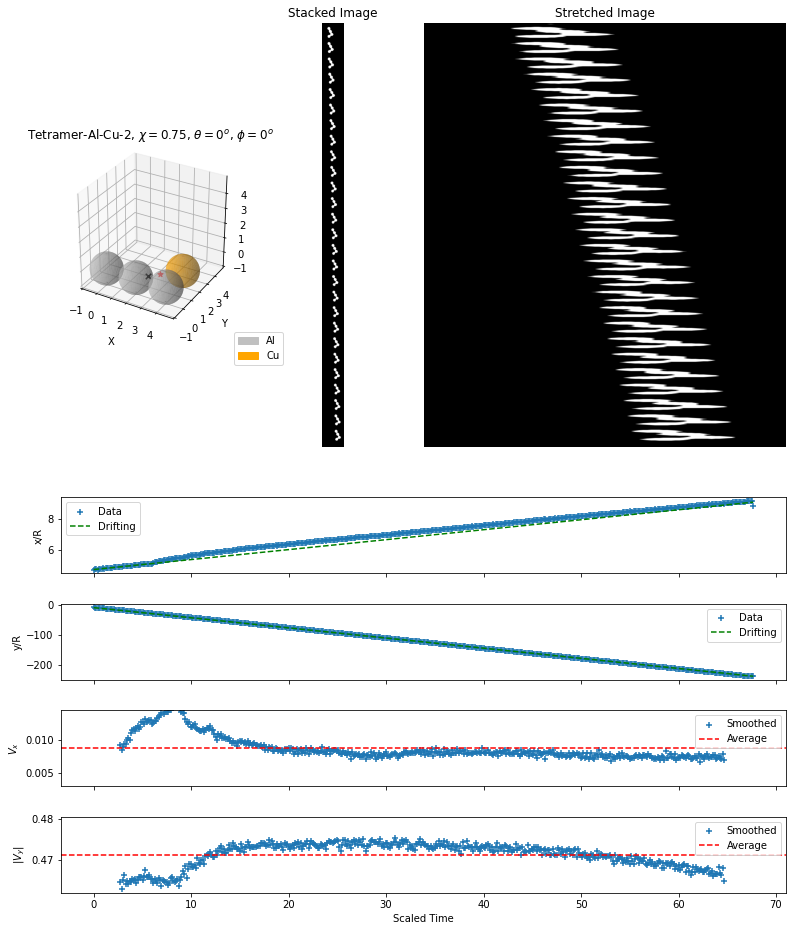

In [163]:
# Create a GridSpec object
fig = plt.figure(figsize=(13, 16))
gs = gridspec.GridSpec(2, 4)  # 2 rows and 4 columns

# Create subplots
ax1 = plt.subplot(gs[0, 0], projection='3d')  # Top left for 3D particle model
ax2 = plt.subplot(gs[0, 1])  # Top middle for the stacked image
ax3 = plt.subplot(gs[0, 2:5])  # Top right for the stretched image, which spans 3 columns
ax4 = plt.subplot(gs[1, :])  # Bottom for the particle's motion

# Plot in each subplot
# 1. Plot the 3D particle model
p = create_particle(config_name)
plot_particle(p, config_name, ax=ax1, transparency=True)

# 2. Plot the stacked and stretched image
tif_path = os.path.join(glacier_path, folder_name, folder_name + ' binary crop.tif')  # specify the location of binary image
frames = io.imread(tif_path)  # import the binary image sequence
stacked_image = plot_stacked_image(frames, ax=ax2)  # stack the images
plot_stretched_image(stacked_image, ax=ax3)  # pass the stacked image and then stretch it

# 3. Plot the motion
tracking_data = pd.read_csv(os.path.join(glacier_path, folder_name, folder_name + ' binary.csv'))  # import the .csv tracking data
fps = int(re.findall(r'(\d+)fps', folder_name)[0])  # extract the frame rate from the folder name using regex
v_light_term = TERMINAL_VELOCITIES[name_light]  # read the terminal velocity of the lightest object
tau = RADIUS / v_light_term  # calculate the time scale
plot_motion(tracking_data, scale=7.12, frame_rate=fps, time_scale=tau, diff_method="forward-difference", avg_size=20, ax=ax4)

# Adjust the layout
fig.subplots_adjust(hspace=0.05, wspace=0.01)

# Save the figure with 600 dpi
plt.savefig(os.path.join('config_figure', folder_name + '.png'), dpi=600, bbox_inches='tight')

# Show the plot
plt.show()